# Abflussmodellierung mittels Potenzfunktion
Dieses Notebook basiert auf einer nichtlinearen Regression der Form: 
\[ Q = a \cdot (h - h_0)^b \]
zur Modellierung des Abflusses in Abhängigkeit vom hydraulischen Potential.

Erstellt am: 2025-05-15

In [28]:
# 📦 Installiere erforderliche Pakete (nur beim ersten Mal nötig)
# Entferne die Kommentarzeichen, wenn du in Google Colab arbeitest
# install.packages('terra')
# install.packages('mgcv')
# install.packages('dplyr')

library(terra)
library(mgcv)
library(dplyr)

In [29]:
library(terra)
library(mgcv)
library(dplyr)

## 📥 Einlesen der PQ-Daten

[1] "ID"    "X"     "Y"     "Curve"

,ID,X,Y,Curve
,<int>,<dbl>,<dbl>,<chr>
1,5,0.000000000,2916.517,Abstrom_Nodes
2,5,0.001000000,-30846.465,Abstrom_Nodes
3,5,0.005198558,-30845.896,Abstrom_Nodes
4,5,0.014272820,-30844.789,Abstrom_Nodes
5,5,0.025597308,-30843.645,Abstrom_Nodes
6,5,0.055187057,-30841.410,Abstrom_Nodes


[1] "✅"


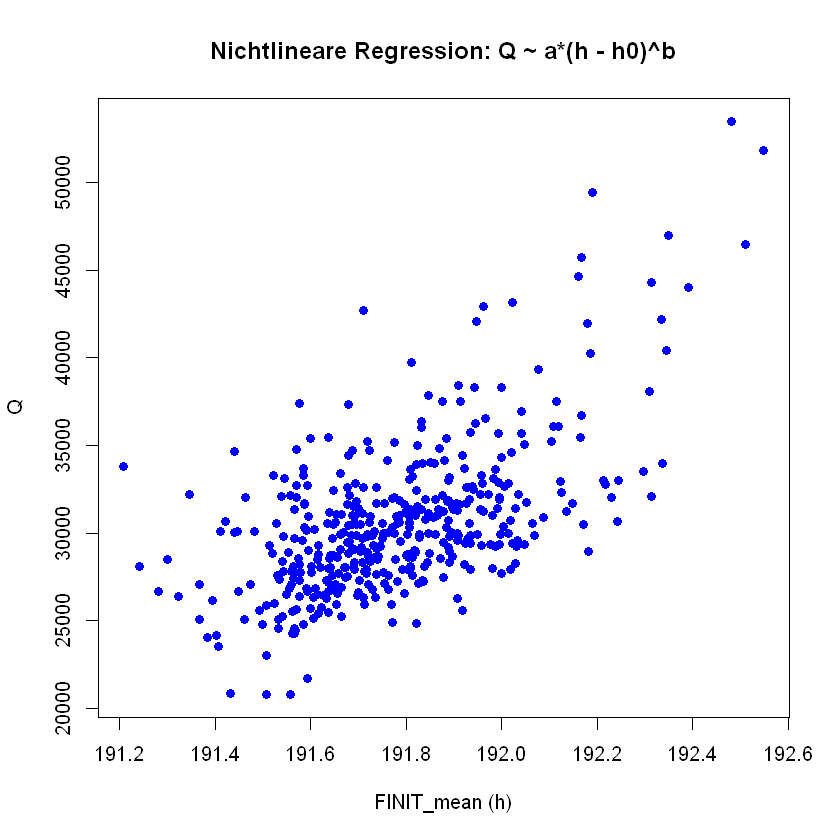

In [30]:
df_pq <- read.csv("./abstrom_aggregiert_subdomain_durchfluss.dat", sep=";")

abfluss_history_charting <- read.csv("./Budget_History_charting_abstrom_flux.dat", sep="")
names(abfluss_history_charting)
head( abfluss_history_charting)
plot(df_pq$h, df_pq$Q, pch = 19, col = "blue",
     main = "Nichtlineare Regression: Q ~ a*(h - h0)^b", xlab = "FINIT_mean (h)", ylab = "Q")
print('✅')

## 📈 Schätzung Startwerte via Log-Log

In [31]:
h0_start <- min(df_pq$h, na.rm = TRUE) - 0.01
df_valid <- subset(df_pq, h > (h0_start + 0.01) & Q > 0)
log_model <- lm(log(Q) ~ log(h - h0_start), data = df_valid)
b_start <- as.numeric(coef(log_model)[2])
a_start <- exp(as.numeric(coef(log_model)[1]))

## 🔁 Nichtlineare Regression

In [32]:
model_nls <- nls(Q ~ a * (h - h0)^b,
                 data = df_valid,
                 start = list(a = a_start, h0 = h0_start, b = b_start),
                 algorithm = "port",
                 lower = c(a = 0, h0 = h0_start - 0.5, b = 0.1),
                 upper = c(a = 1e6, h0 = h0_start + 0.5, b = 5),
                 control = list(maxiter = 1000, warnOnly = TRUE))
summary(model_nls)


Formula: Q ~ a * (h - h0)^b

Parameters:
    Estimate Std. Error t value Pr(>|t|)    
a  2.971e+04  6.054e+03   4.907 1.31e-06 ***
h0 1.907e+02  4.536e-01 420.389  < 2e-16 ***
b  4.425e-01  1.889e-01   2.343   0.0196 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3451 on 429 degrees of freedom

Algorithm "port", convergence message: both X-convergence and relative convergence (5)


Warning message in df_pq$Q - preds:
"Länge des längeren Objektes
 	 ist kein Vielfaches der Länge des kürzeren Objektes"


[1] "✅"


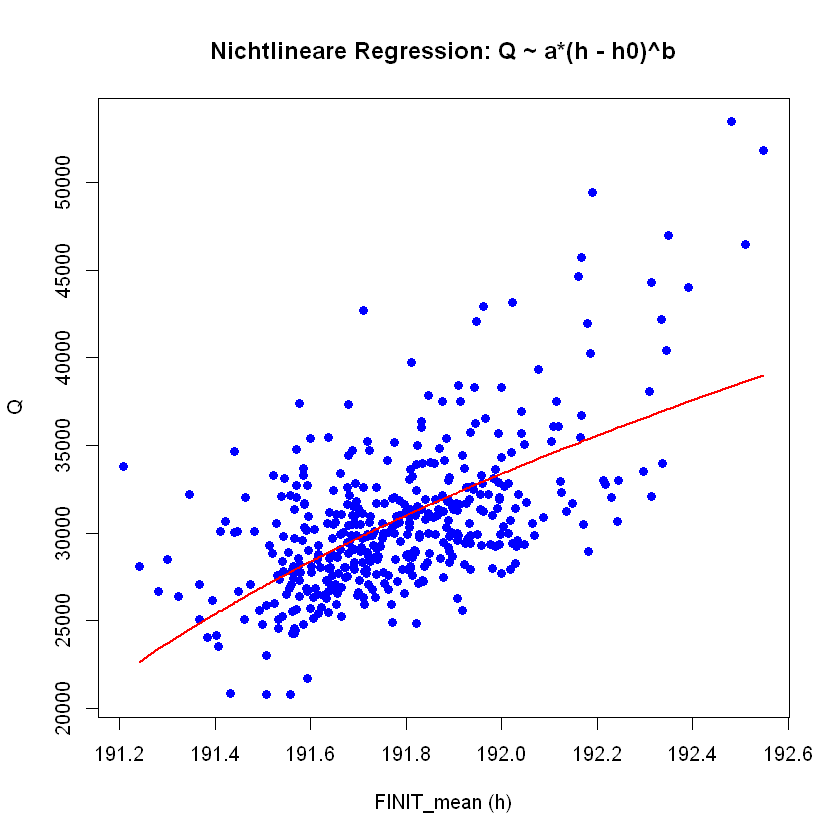

In [33]:
preds <- predict(model_nls)
rmse <- sqrt(mean((df_pq$Q - preds)^2))
plot(df_pq$h, df_pq$Q, pch = 19, col = "blue",
     main = "Nichtlineare Regression: Q ~ a*(h - h0)^b", xlab = "FINIT_mean (h)", ylab = "Q")
lines(sort(df_valid$h), predict(model_nls, newdata = data.frame(h = sort(df_valid$h))), col = "red", lwd = 2)
print('✅')

## 📌 Koeffizienten und Bereichsauswertung

In [34]:
coef(model_nls)
a <- coef(model_nls)[["a"]]
h0 <- coef(model_nls)[["h0"]]
b <- coef(model_nls)[["b"]]

range_head = c(191, 193)
q_result_min <- a*( range_head[1]- h0 )^b
q_result_max <- a*( range_head[2]- h0 )^b

area = 427960
q_result_min / area
q_result_max / area

a           h0            b 
2.970679e+04 1.906990e+02 4.424756e-01

[1] 0.04080897

[1] 0.1003679

## 📦 Verarbeitung der Shapefiles

In [35]:
abstrom <- terra::vect("./V11_Abstrom_Nodes_Hyhead_Darcy_Flux_Rate_budget.shp", crs = "+init=epsg:31467")
abstrom <- data.frame(abstrom)
aggregiert_df <- abstrom %>%
  group_by(TIME) %>%
  summarise(
    FINIT_mean = mean(FINIT, na.rm = TRUE),
    BDRFLOW_sum = -sum(BDRFLOW, na.rm = TRUE),
    VINIT_mean = mean(VINIT, na.rm = TRUE)
  )

Warning message:
"[crs<-] Z coordinates ignored"


In [36]:
abstrom_result <- terra::vect("./V11_Abstrom_Nodes_Hyhead_Darcy_Flux_Rate_budget_period_expression_editor.shp", crs = "+init=epsg:31467")
abstrom_result <- data.frame(abstrom_result)
aggregiert_df_result <- abstrom_result %>%
  group_by(TIME) %>%
  summarise(
    FINIT_mean = mean(FINIT, na.rm = TRUE),
    BDRFLOW_sum = -sum(BDRFLOW, na.rm = TRUE),
    VINIT_mean = mean(VINIT, na.rm = TRUE)
  )

Warning message:
"[crs<-] Z coordinates ignored"


## 📊 Zeitliche Entwicklung

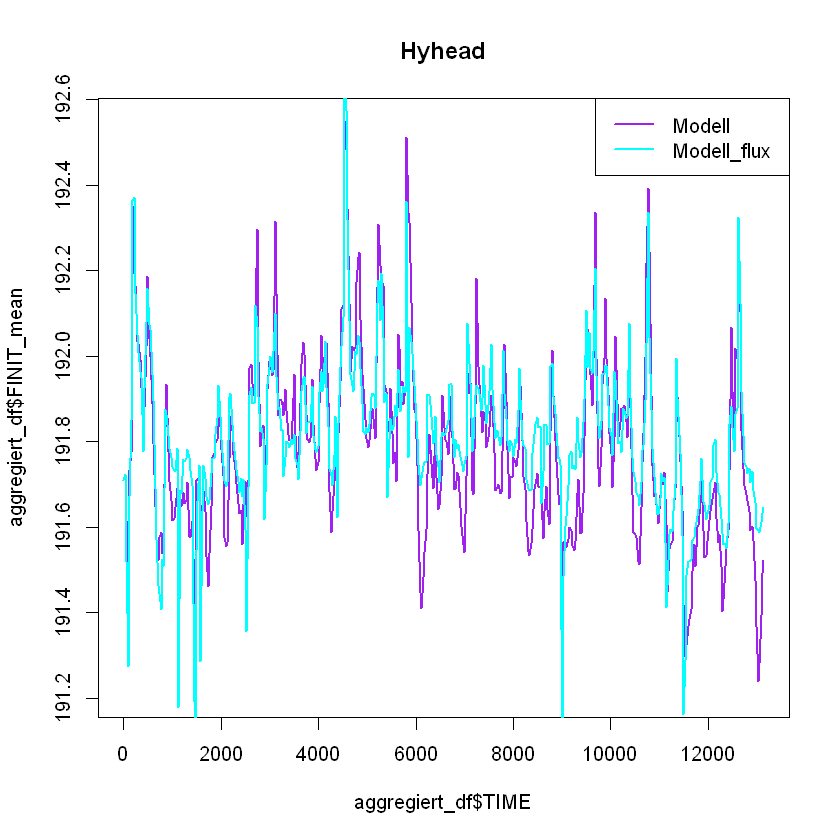

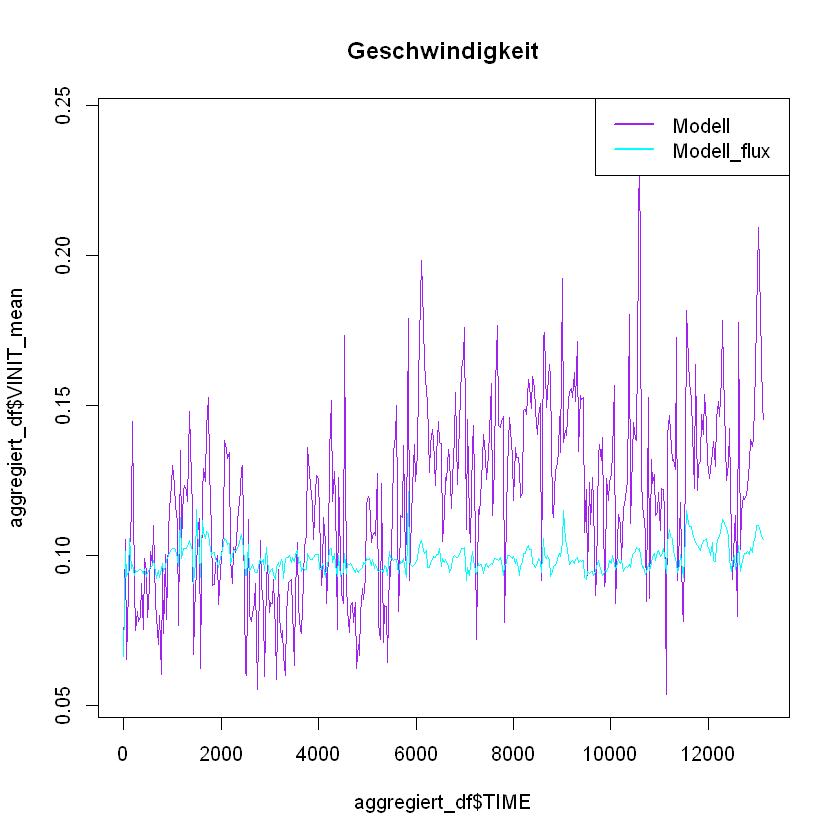

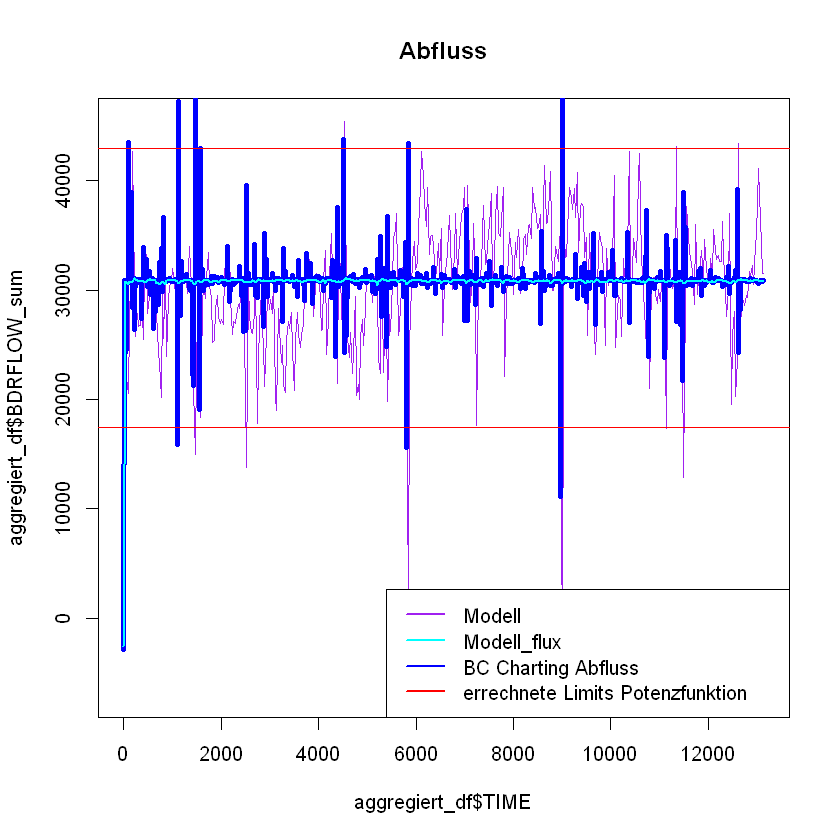

In [ ]:
# Hydraulic head
# Hydraulic head
plot(aggregiert_df$TIME, aggregiert_df$FINIT_mean, type="l", col="purple", main = "Hyhead", lwd= 2)
lines(aggregiert_df_result$TIME, aggregiert_df_result$FINIT_mean, col="cyan", lwd= 2)
legend( "topright", legend = c( "Modell", "Modell_flux"), col=c("purple", "cyan"), lwd= 2)

# Geschwindigkeit
plot(aggregiert_df$TIME, aggregiert_df$VINIT_mean, type="l", col="purple", main = "Geschwindigkeit")
lines(aggregiert_df_result$TIME, aggregiert_df_result$VINIT_mean, col="cyan")
legend( "topright", legend = c( "Modell", "Modell_flux"), col=c("purple", "cyan"), lwd= 2)

# Abfluss
plot(aggregiert_df$TIME, aggregiert_df$BDRFLOW_sum, type="l", col="purple", main = "Abfluss")
lines(abfluss_history_charting$X, -abfluss_history_charting$Y, col="blue", lwd = 4 )
lines(aggregiert_df$TIME,aggregiert_df_result$BDRFLOW_sum, col="cyan",  lwd = 2)
legend( "bottomright", legend = c( "Modell", "Modell_flux", "BC Charting Abfluss", "errechnete Limits Potenzfunktion" ), col=c("purple", "cyan", "blue", "red"), lwd= 2)

# Referenzlinien
abline(h = q_result_min, col="red")
abline(h = q_result_max, col="red")